In [ ]:
%reload_ext autoreload
%autoreload 2

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

from dataset.graph_builder import GraphBuilder

builder = GraphBuilder(dataset_paths=["data/BALANCED/test.json"], dataset_names=["BALANCED"], dataset_type='test')
builder()

In [ ]:
builder.display_graph(1)

In [ ]:
builder.save_graphs('data/BALANCED/graphs')

In [ ]:
import os 

os.path.isdir('data/UNIFIED')

In [5]:
import torch 
import os 
x = torch.load(os.path.join('data/BALANCED/graphs/test', '556.pt'), map_location='cpu')
x 

HeteroData(
  edu={ x=[8, 2304] },
  (edu, QAP, edu)={ edge_index=[2, 1] },
  (edu, Comment, edu)={ edge_index=[2, 4] },
  (edu, Clarification_question, edu)={ edge_index=[2, 2] }
)

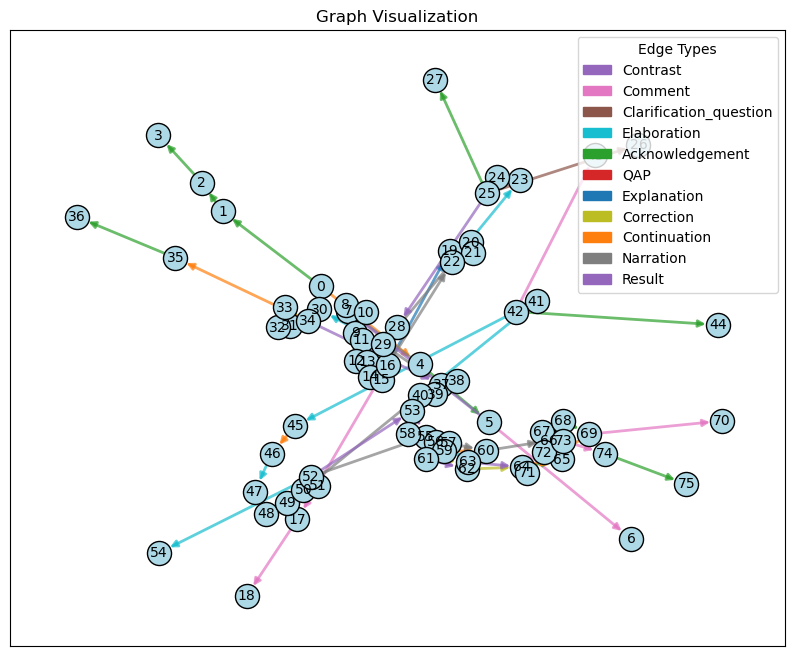

In [3]:
from utils import display_graph 
import torch 

display_graph(torch.load('data/BALANCED/graphs/test/212.pt', map_location='cpu'))